# Topic 3: Recommendation System
### Demo: Gemsim, Cosin Similarity

In [7]:
!pip install gensim

In [1]:
!pip install googletrans==4.0.0-rc1

In [2]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings
from gensim import corpora, models, similarities
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from googletrans import Translator
from time import sleep

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/DL07_K304_VoMinhTri_PhamThiThuThao/Project02'
#%cd '/content/gdrive/MyDrive/DL07_K304_VoMinhTri_PhamThiThuThao/Project02'

/content/gdrive/MyDrive/Colab Notebooks/DL07_K304_VoMinhTri_PhamThiThuThao/Project02


##**ĐỌC VÀ XEM THÔNG TIN CƠ BẢN**

In [7]:
data = pd.read_excel("Overview_Companies.xlsx")
data_review = pd.read_excel("Reviews.xlsx")
# Chú ý: Đây là các công ty có "Company overview" tiếng Anh, khi thực hiện thì phải chuẩn về 1 ngôn ngữ để đề xuất

In [5]:
data.head(3)

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n
2,2,52 Entertainment,IT Product,Game,1-50 employees,France,Monday - Friday,No OT,A start-up of French and Vietnamese guys with ...,Our Key Skills\nJava\nGames\nQA QC\nC#\nUnity\...,Be your own boss\nA free lunch and a half day ...,"{'Ho Chi Minh': ['Tầng 7, 23 Trần Cao Vân, Phư...",https://itviec.com/companies/52-entertainment\n


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            478 non-null    int64 
 1   Company Name                  478 non-null    object
 2   Company Type                  478 non-null    object
 3   Company industry              463 non-null    object
 4   Company size                  478 non-null    object
 5   Country                       478 non-null    object
 6   Working days                  476 non-null    object
 7   Overtime Policy               447 non-null    object
 8   Company overview              478 non-null    object
 9   Our key skills                321 non-null    object
 10  Why you'll love working here  379 non-null    object
 11  Location                      478 non-null    object
 12  Href                          478 non-null    object
dtypes: int64(1), object(

In [7]:
null_data = data[data.isnull().any(axis=1)]
display(null_data)

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n
3,3,8Seneca,IT Outsourcing,IT Services and IT Consulting,1-50 employees,Singapore,Monday - Friday,No OT,Pure play IT team extensions B2b exclusive out...,NaN,"Ha Noi\n19F, Coninco Tower 4 Tôn Thất Tùng, Do...","{'Ha Noi': ['19F, Coninco Tower 4 Tôn Thất Tùn...",https://itviec.com/companies/8seneca\n
7,7,AI AVATAR,IT Product,Software Products and Web Services,1-50 employees,Vietnam,Monday - Friday,Extra salary for OT,Create a world where you can love yourself\nAt...,NaN,"Ha Noi\n3rd Floor, IPH Shopping Center, 241 Xu...","{'Ha Noi': ['3rd Floor, IPH Shopping Center, 2...",https://itviec.com/companies/ai-avatar\n
11,11,Alliex Vietnam,IT Service and IT Consulting,Financial Services,51-150 employees,South Korea,Monday - Friday,No OT,Alliex is a leading provider in development an...,NaN,"Ha Noi\nUnit 4301-08 , 43rd Floor, Keangnam Ha...","{'Ha Noi': ['Unit 4301-08 , 43rd Floor, Keangn...",https://itviec.com/companies/alliex-vietnam\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,461,VNGGames,IT Product,Software Products and Web Services,501-1000 employees,Vietnam,Monday - Friday,No OT,"VNGGames - BE GLOBAL, BE GAME CHANGER\nVNGGame...",NaN,"Ho Chi Minh\nZ06 Đường số 13, Phường Tân Thuận...","{'Ho Chi Minh': ['Z06 Đường số 13, Phường Tân ...",https://itviec.com/companies/vnggames\n
464,464,VRB,Non-IT,Banking,501-1000 employees,Vietnam,Monday - Friday,NaN,Ngân hàng liên doanh Việt - Nga\nNgày 19/11/20...,SQL\n.NET\nOracle\nJava\nASP.NET,Môi trường làm việc năng động\nChế độ phúc lợi...,"{'Ha Noi': ['75 Trần Hưng Đạo, Hoàn Kiếm, Hà N...",https://itviec.com/companies/vrb\n
469,469,Xavis Tech,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,Xavis Tech JSC\nWith the emerging smart factor...,NaN,"Ha Noi\n3rd Floor, 3D Creative Center Building...","{'Ha Noi': ['3rd Floor, 3D Creative Center Bui...",https://itviec.com/companies/xavis-tech\n
470,470,XionTech,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,XionTech\nInspired by the spiritual vision of ...,NaN,NaN,"{'Ho Chi Minh': ['Tháp A2, Tòa nhà Viettel, 28...",https://itviec.com/companies/xiontech\n


In [8]:
cols = [
    "Company Type",
    "Company industry",
    "Company size",
    "Country",
    "Working days",
    "Overtime Policy"
]

# In số lượng giá trị khác nhau ở từng cột
for col in cols:
    print(f"{col}: {data[col].nunique()} giá trị khác nhau")

Company Type: 4 giá trị khác nhau
Company industry: 33 giá trị khác nhau
Company size: 6 giá trị khác nhau
Country: 26 giá trị khác nhau
Working days: 2 giá trị khác nhau
Overtime Policy: 4 giá trị khác nhau


##**LÀM SẠCH DỮ LIỆU**

- Điền giá trị null cột Overtime Policy, Company industry, Working days bằng 'Unknown'
- Gộp 3 cột nd text tự do là [Company overview, Our key skills, Why you'll love working here] -> 'noidung_cty' -> Xử lý cột noidung_cty bằng: chuyển Hoa thường, bỏ dấu câu, chuyển Anh-Viet,... dùng def clean_pipeline(text) ở project1 -> 'clean_text_cty'
- 6 cột nội dung phân loại "Company Type", "Company industry", "Company size", "Country", "Working days", "Overtime Policy" -> nối liền bằng dấu '_' để không tách nhau ra khi phân từ trong gensim
- Tạo cột nội dung đầu vào cho gensim bằng nội dung '6 cột cố định' -> 'input_text

In [9]:
cols_to_fill = ['Overtime Policy', 'Company industry', 'Working days', 'Our key skills' , "Why you'll love working here"]

# Điền giá trị 'Unknown' vào các ô bị thiếu trong từng cột
data[cols_to_fill] = data[cols_to_fill].fillna('Unknown')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            478 non-null    int64 
 1   Company Name                  478 non-null    object
 2   Company Type                  478 non-null    object
 3   Company industry              478 non-null    object
 4   Company size                  478 non-null    object
 5   Country                       478 non-null    object
 6   Working days                  478 non-null    object
 7   Overtime Policy               478 non-null    object
 8   Company overview              478 non-null    object
 9   Our key skills                478 non-null    object
 10  Why you'll love working here  478 non-null    object
 11  Location                      478 non-null    object
 12  Href                          478 non-null    object
dtypes: int64(1), object(

####**Làm sạch 3 cột nội dung tự do**

In [10]:
translator = Translator()

def safe_translate_vi(text):
    try:
        result = translator.translate(text, dest='vi')
        return result.text
    except Exception as e:
        print("Retrying after error:", e)
        sleep(1)
        return ""

In [11]:
data['Company overview_new'] = data['Company overview'].apply(safe_translate_vi)
data[ "Why you'll love working here_new"] = data["Why you'll love working here"].apply(safe_translate_vi)
data['Our key skills_new'] = data['Our key skills'].apply(safe_translate_vi)

In [12]:
data[['Company overview_new', "Why you'll love working here_new",'Our key skills_new']].head()

,Company overview_new,Why you'll love working here_new,Our key skills_new
0,1BITLAB Technology\nCông ty cổ phần công nghệ ...,Không xác định,Không xác định
1,1test\nLà một công ty công nghệ giáo dục sáng ...,Không xác định,Không xác định
2,Một người khởi nghiệp của những người Pháp và ...,Là ông chủ của riêng bạn\nBữa trưa miễn phí và...,Kỹ năng chính của chúng tôi\nJava\nTrò chơi\nQ...
3,Pure Play IT Team Extensions B2B Độc quyền của...,"Ha Noi\n19F, Coninco Tower 4 Tôn Thất Tùng, Do...",Không xác định
4,Một công ty dịch vụ chuyên nghiệp toàn cầu có ...,Làm việc lai\nMôi trường tập trung tuyệt vời v...,Kỹ năng chính của chúng tôi\nĐám mây\nLinux\nD...


In [14]:
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

#LOAD STOPWORDS
file = open('files/vietnamese-stopwords_rev.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()


In [15]:
# Làm sạch văn bản
def clean_text(text):
    text = text.lower() #Hoa -> thường
    text = re.sub(rf"[{string.punctuation}]", "", text) #Bỏ dấu câu
    text = re.sub(r"\b(g|ml)\b", "", text)  # Bỏ từ 'g' hoặc 'ml' khi nó là cả từ
    text = re.sub(r"\s+", " ", text).strip()  # Xóa khoảng trắng thừa
    text = re.sub(r"^[\-\+\*\•\●\·\~\–\—\>]+", "", text) # Bỏ dấu đầu câu
    return text

def fix_teencode(text, mapping):
    words = text.split()
    corrected = [mapping.get(word, word) for word in words]
    return " ".join(corrected)


def remove_stopword(text, stopword_dict):
    words = text.split()
    stopword = [word for word in words if word not in stopword_dict]
    return " ".join(stopword)

def clean_pipeline(text):
    text = clean_text(text)
    # text = safe_translate_vi(text)
    text = fix_teencode(text, teen_dict)
    # text = remove_wrongword(text, wrong_lst)
    text = remove_stopword(text, stopwords_lst)
    return text


In [16]:
data['Company overview_new'] = data['Company overview_new'].apply(clean_pipeline)
data[ "Why you'll love working here_new"] = data["Why you'll love working here_new"].apply(clean_pipeline)
data['Our key skills_new'] = data['Our key skills_new'].apply(clean_pipeline)

In [17]:
#Gộp 3 cột nội dung tự do vào 1 cột
data['noidung_cty']=data['Company overview_new'].fillna('') + ' ' + data['Our key skills_new'].fillna('') + ' ' + data["Why you'll love working here_new"].fillna('')

In [44]:
data[['Company overview', "Why you'll love working here",'Our key skills','noidung_cty']].head()

,Company overview,Why you'll love working here,Our key skills,noidung_cty
0,1BITLAB Technology\nCông ty cổ phần công nghệ ...,Unknown,Unknown,1bitlab technology công ty cổ công nghệ 1bitla...
1,1test\nIs an innovative educational technology...,Unknown,Unknown,1test công ty công nghệ giáo dục cam kết đổi t...
2,A start-up of French and Vietnamese guys with ...,Be your own boss\nA free lunch and a half day ...,Our Key Skills\nJava\nGames\nQA QC\nC#\nUnity\...,khởi nghiệp pháp việt nam niềm đam mê phát tri...
3,Pure play IT team extensions B2b exclusive out...,"Ha Noi\n19F, Coninco Tower 4 Tôn Thất Tùng, Do...",Unknown,pure play it team extensions b2b độc quyền chu...
4,A global professional services company with le...,Hybrid working\nWonderful and Human focus Envi...,Our Key Skills\nCloud\nLinux\nDevOps\nNetworki...,công ty dịch vụ chuyên nghiệp toàn cầu khả năn...


####**Làm sạch 6 cột nội dung mặc định**

In [19]:
# Danh sách 6 cột cố định cần nối bằng dấu _
fixed_cols = ["Company Type", "Company industry", "Company size", "Country", "Working days", "Overtime Policy"]

# Nối từ trong từng ô bằng dấu _
for col in fixed_cols:
    data[col] = data[col].astype(str).str.replace(r'\s+', '_', regex=True)
data[["Company Type", "Company industry", "Company size", "Country", "Working days", "Overtime Policy"]].head(2)

,Company Type,Company industry,Company size,Country,Working days,Overtime Policy
0,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Vietnam,Monday_-_Friday,No_OT
1,IT_Product,IT_Services_and_IT_Consulting,1-50_employees,South_Korea,Monday_-_Friday,No_OT


In [20]:
#Tạo cột nội dung đầu vào cho gensim bằng nội dung '6 cột cố định' và cột 'clean_text_cty' vừa xử lý dữ liệu -> 'input_gensim'
#data['input_text'] = data[["Company Type", "Company industry", "Company size", "Country", "Working days", "Overtime Policy", "noidung_cty"]].astype(str).agg(' '.join, axis=1)
data['input_text'] = data[["Company Type", "Company industry", "Company size", "Country", "Working days", "Overtime Policy"]].astype(str).agg(' '.join, axis=1)

data['input_text'].head(3)

,input_text
0,IT_Outsourcing Software_Development_Outsourcin...
1,IT_Product IT_Services_and_IT_Consulting 1-50_...
2,IT_Product Game 1-50_employees France Monday_-...


##**TÌM CÔNG TY TƯƠNG TỰ BẰNG GENSIM**


In [21]:
# Tokenize(split) the sentences into words
df_gem = [[text for text in x.split()] for x in data.input_text]

# Tạo từ điển với danh sách từ, mỗi từ gắn 1 chỉ số id (Dictionary có (id2token: token2id: count) = (id từ: từ gốc: tần số))
dictionary = corpora.Dictionary(df_gem)

# Tạo bảng tần số (id của từ, tần số từ)
corpus = [dictionary.doc2bow(text) for text in df_gem]

# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus)

# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)

# tính toán sự tương tự trong ma trận thưa thớt (tạo ma trận vector [a,b], chưa tính)
index = similarities.SparseMatrixSimilarity(tfidf[corpus],
                                            num_features = feature_cnt)

In [22]:
#Xem chiều dài
len(df_gem)

478

In [23]:
#Xem nội dung
df_gem[:1]

[['IT_Outsourcing',
  'Software_Development_Outsourcing',
  '1-50_employees',
  'Vietnam',
  'Monday_-_Friday',
  'No_OT']]

In [24]:
# Xem list (từ gốc: id từ)
dictionary.token2id

{'1-50_employees': 0,
 'IT_Outsourcing': 1,
 'Monday_-_Friday': 2,
 'No_OT': 3,
 'Software_Development_Outsourcing': 4,
 'Vietnam': 5,
 'IT_Product': 6,
 'IT_Services_and_IT_Consulting': 7,
 'South_Korea': 8,
 'France': 9,
 'Game': 10,
 'Singapore': 11,
 '301-500_employees': 12,
 'IT_Service_and_IT_Consulting': 13,
 '51-150_employees': 14,
 'Switzerland': 15,
 'E-commerce': 16,
 'Extra_salary_for_OT': 17,
 'Software_Products_and_Web_Services': 18,
 'Japan': 19,
 'Financial_Services': 20,
 'AI,_Blockchain_and_Deep_Tech_Services': 21,
 '151-300_employees': 22,
 'United_States': 23,
 'Manufacturing_and_Engineering': 24,
 'Monday_-_Saturday': 25,
 'Education_and_Training': 26,
 'Unknown': 27,
 'United_Arab_Emirates': 28,
 'Malaysia': 29,
 'Canada': 30,
 'Real_Estate,_Property_and_Construction': 31,
 'Cambodia': 32,
 '501-1000_employees': 33,
 '1000+_employees': 34,
 'Non-IT': 35,
 'Pharmaceuticals': 36,
 'Germany': 37,
 'Creative_and_Design': 38,
 'United_Kingdom': 39,
 'Transportation,_Lo

In [25]:
# Xem số lượng từ có trong từ điển
len(dictionary.token2id)

76

In [26]:
#Xem list từ điển của công ty thứ 3 (id từ: tần số)
corpus[3]

[(0, 1), (1, 1), (2, 1), (3, 1), (7, 1), (11, 1)]

####**BT1: Chọn 1 công ty -> hiển thị công ty tương tự**

- Lấy vector tfidf của công ty được chọn -> tính sim -> tra với danh mục index -> xuất trả danh sách

In [53]:
def find_similar_companies_gem(company_id, corpus, tfidf, index, top_n=5):
    # 1. Lấy vector TF-IDF của công ty được chọn
    tfidf_vec = tfidf[corpus[company_id]]

    # 2. Tính cosine similarity giữa công ty này và tất cả các công ty khác
    sims = index[tfidf_vec]  # (Là tính cosin giữa vector hỏi và matran vector đang có, cosin gần 1 thì càng // hay trùng nhau: [a, b] x [b, 1] = [a, 1])

    # 3. Sắp xếp theo độ tương tự giảm dần, loại chính nó ra, lấy top 5
    top_similar_gem_find = sorted([(i, sim) for i, sim in enumerate(sims) if i != company_id],key=lambda x: x[1],reverse=True)[:top_n]

    # 4. Lấy ID và similarity
    company_ids = [i[0] for i in top_similar_gem_find]
    similarities = [round(i[1], 4) for i in top_similar_gem_find]

    # 5. Lấy dữ liệu từ gốc
    df_gem_find = data.iloc[company_ids].copy()
    df_gem_find['similarity'] = similarities

    return df_gem_find, top_similar_gem_find, company_id

# Áp dụng công thức, trả ra danh sách top_5 id công ty tương đồng nhất và bảng df thông tin chi tiết
df_gem_find, top_similar_gem_find, company_id = find_similar_companies_gem(company_id=10, corpus=corpus, tfidf=tfidf, index=index, top_n=5)

print(f"ID của công ty đang tìm kiếm: {company_id}"
        "\n\nID của các công ty tương tự:")

# Xem top_5 id công ty tương đồng nhất
for idx, score in top_similar_gem_find:
    print(f"ID: {idx}, Similarity_score: {score:.4f}")

ID của công ty đang tìm kiếm: 10

ID của các công ty tương tự:
ID: 64, Similarity_score: 0.9115
ID: 194, Similarity_score: 0.9115
ID: 445, Similarity_score: 0.9115
ID: 308, Similarity_score: 0.8434
ID: 302, Similarity_score: 0.8026


In [28]:
df_gem_find

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href,Company overview_new,Why you'll love working here_new,Our key skills_new,noidung_cty,input_text,similarity
64,64,CIRCLACE HT,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Japan,Monday_-_Friday,No_OT,CIRCLACE HT\nĐáp ứng nhu cầu toàn cầu ngày càn...,Unknown,Unknown,"{'Ho Chi Minh': ['90 Nguyễn Đình Chiểu, Đa Kao...",https://itviec.com/companies/circlace-ht\n,circlace ht đáp ứng nhu cầu toàn cầu đổi dx xu...,không xác định,không xác định,circlace ht đáp ứng nhu cầu toàn cầu đổi dx xu...,IT_Outsourcing Software_Development_Outsourcin...,0.9115
194,194,GENKI SYSTEM,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Japan,Monday_-_Friday,No_OT,Embrace Challenges & Grow Together !\nOUR ENVI...,KEY SKILLS :\nVueJS\nGolang\nReactJS\nAWS\nFlu...,Positive & funny Work Environment\nOpen cultur...,"{'Ho Chi Minh': ['168 Cao Đức Lân, An Phú, Thu...",https://itviec.com/companies/genki-system\n,nắm thử thách phát triển môi trường quyền sở h...,môi trường tích cực hài hước văn hóa đồng nghi...,kỹ năng vuejs golang reactjs aws rung động pyt...,nắm thử thách phát triển môi trường quyền sở h...,IT_Outsourcing Software_Development_Outsourcin...,0.9115
445,445,"Vareal Vietnam Co., Ltd",IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Japan,Monday_-_Friday,No_OT,Vareal Việt Nam là công ty chuyên về lĩnh vực ...,CSS\nRuby on Rails\nRuby\nHTML5\nLinux\nJavaSc...,Attractive salary based on skills and experien...,"{'Ha Noi': ['4th Floor, 87 Tran Thai Tong, Dic...",https://itviec.com/companies/vareal-vietnam-co...,vareal việt nam công ty chuyên lĩnh vực công n...,attractive salary based on skills and experien...,css ruby đường ray ruby html5 linux javascript,vareal việt nam công ty chuyên lĩnh vực công n...,IT_Outsourcing Software_Development_Outsourcin...,0.9115
308,308,Neos Việt Nam,IT_Outsourcing,Software_Development_Outsourcing,51-150_employees,Japan,Monday_-_Friday,Unknown,Neos VN là công ty IT 100% vốn Nhật Bản chuyên...,Bridge Engineer\nFlutter\nPHP\nJavaScript\nPyt...,Đóng Bảo hiểm xã hội 100% lương tháng\nCơ hội ...,"{'Ha Noi': ['Tầng 7, tòa nhà Ocean Park, số 1 ...",https://itviec.com/companies/neos-viet-nam\n,neos việt nam công ty it 100 vốn nhật chuyên s...,đóng bảo hiểm xã hội 100 lương cơ hội thăng ti...,kỹ sư cầu rung động php javascript python,neos việt nam công ty it 100 vốn nhật chuyên s...,IT_Outsourcing Software_Development_Outsourcin...,0.8434
302,302,NAL Việt Nam,IT_Outsourcing,Software_Development_Outsourcing,151-300_employees,Japan,Monday_-_Friday,No_OT,Đồng hành cùng NAL Việt Nam trên chặng đường p...,Our Key Skills\nJava\nPHP\nJavaScript\nRuby on...,100% nhân viên được cấp máy Mac để làm việc.\n...,"{'Ha Noi': ['Tầng 4, Toà Novo, Kosmo Tây Hồ, s...",https://itviec.com/companies/nal-viet-nam\n,đồng hành nal việt nam chặng đường phủ sóng đồ...,100 nhân viên máy mac review lương 6 thánglần ...,our key skills java php javascript ruby on rai...,đồng hành nal việt nam chặng đường phủ sóng đồ...,IT_Outsourcing Software_Development_Outsourcin...,0.8026


####**BT2: Gõ từ khóa vào và hiển thị list công ty tương tự**

- Chuyển từ khóa -> làm sạch -> chuyển vector -> tính sim -> tra với danh mục index -> xuất trả danh sách

In [29]:
# Tokenize(split) the sentences into words
df_gem_2 = [[text for text in x.split()] for x in data.noidung_cty]

# Tạo từ điển với danh sách từ, mỗi từ gắn 1 chỉ số id (Dictionary có (id2token: token2id: count) = (id từ: từ gốc: tần số))
dictionary_2 = corpora.Dictionary(df_gem_2)

# Tạo bảng tần số (id của từ, tần số từ)
corpus_2 = [dictionary_2.doc2bow(text) for text in df_gem_2]

# Use TF-IDF Model to process corpus, obtaining index
tfidf_2 = models.TfidfModel(corpus_2)

# Numbers of features (word) in dictionary
feature_cnt_2 = len(dictionary_2.token2id)

# tính toán sự tương tự trong ma trận thưa thớt (tạo ma trận vector [a,b], chưa tính)
index_2 = similarities.SparseMatrixSimilarity(tfidf[corpus_2],
                                            num_features = feature_cnt_2)

In [30]:
data['noidung_cty']

,noidung_cty
0,1bitlab technology công ty cổ công nghệ 1bitla...
1,1test công ty công nghệ giáo dục cam kết đổi t...
2,khởi nghiệp pháp việt nam niềm đam mê phát tri...
3,pure play it team extensions b2b độc quyền chu...
4,công ty dịch vụ chuyên nghiệp toàn cầu khả năn...
...,...
473,công nghệ nằm trung tâm giải pháp hướng tiếp t...
474,zen8labs zen8labs công ty tư vấn công nghệ toà...
475,zens company we all things with big heart zens...
476,trung tâm toàn cầu xuất sắc mềm bespoke phù hợ...


In [31]:
dictionary_2.token2id

{'1bitlab': 0,
 'biến': 1,
 'blockchain': 2,
 'bền': 3,
 'chuyên': 4,
 'cntt': 5,
 'cung': 6,
 'công': 7,
 'cơ': 8,
 'cạnh': 9,
 'cận': 10,
 'cổ': 11,
 'giới': 12,
 'hoạt': 13,
 'huyết': 14,
 'hàng': 15,
 'hướng': 16,
 'hội': 17,
 'hợp': 18,
 'không': 19,
 'kiến': 20,
 'liên': 21,
 'lý': 22,
 'lĩnh': 23,
 'môi': 24,
 'mảng': 25,
 'nghiệp': 26,
 'nghệ': 27,
 'ngành': 28,
 'ngũ': 29,
 'nhiệt': 30,
 'nhân': 31,
 'nhật': 32,
 'nâng': 33,
 'phát': 34,
 'quản': 35,
 'technology': 36,
 'thân': 37,
 'thị': 38,
 'thời': 39,
 'thức': 40,
 'tiếp': 41,
 'triển': 42,
 'trường': 43,
 'trẻ': 44,
 'trực': 45,
 'ty': 46,
 'tác': 47,
 'tầm': 48,
 'tục': 49,
 'vững': 50,
 'vực': 51,
 'xác': 52,
 'định': 53,
 'đối': 54,
 'đổi': 55,
 'đội': 56,
 'động': 57,
 '1test': 58,
 'báo': 59,
 'cam': 60,
 'cáo': 61,
 'cường': 62,
 'diện': 63,
 'dục': 64,
 'game': 65,
 'gia': 66,
 'giáo': 67,
 'giải': 68,
 'hiệu': 69,
 'hành': 70,
 'hànhchúng': 71,
 'hóa': 72,
 'học': 73,
 'kinh': 74,
 'kiểm': 75,
 'kết': 76,
 'mlnền

In [78]:
def search_similar_companies_gem(query_text, clean_pipeline, dictionary, tfidf_model, index_2, data, top_n=1):

    # 1. Làm sạch và tách từ
    clean_text = clean_pipeline(query_text)
    tokens = clean_text.split()  # hoặc dùng tokenizer riêng nếu bạn có

    # 2. Chuyển sang dạng vector BoW
    bow_vector = dictionary.doc2bow(tokens)

    # 3. Chuyển sang vector TF-IDF
    tfidf_vector = tfidf_model[bow_vector]

    # 4. Tính độ tương tự với toàn bộ công ty
    sims = index_2[tfidf_vector]

    # 5. Sắp xếp theo độ tương tự giảm dần
    top_similar_gem_search = sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_n]

    # 5. Lấy ID và similarity
    company_ids = [i[0] for i in top_similar_gem_search]
    similarities = [round(i[1], 4) for i in top_similar_gem_search]

    # 6. Lấy dữ liệu từ gốc
    df_gem_search = data.iloc[company_ids].copy()
    df_gem_search['similarity'] = similarities

    return df_gem_search, top_similar_gem_search, query_text

# Áp dụng công thức, trả ra danh sách top_5 id công ty tương đồng nhất và bảng df thông tin chi tiết
df_gem_search, top_similar_gem_search, query_text  = search_similar_companies_gem(
    query_text="CNTT chuyên về mảng Blockchain, AI. Công ty làm việc với khách hàng Nhật Bản",
    clean_pipeline=clean_pipeline,
    dictionary=dictionary_2,
    tfidf_model=tfidf_2,
    index_2=index_2,
    data=data,
    top_n=1
)

print (f"Từ khóa tìm kiếm: {query_text}")
print (f"\nID và chỉ số tương đồng của công ty gần nhất với từ khóa cần tìm là:")
# Vì top_n = 1 nên lấy phần tử đầu tiên trong top_similar_gem_search
idx, score = top_similar_gem_search[0]
print(f"ID: {idx}, Similarity_score: {score:.4f}")

Từ khóa tìm kiếm: CNTT chuyên về mảng Blockchain, AI. Công ty làm việc với khách hàng Nhật Bản

ID và chỉ số tương đồng của công ty gần nhất với từ khóa cần tìm là:
ID: 445, Similarity_score: 0.2364


In [62]:
df_gem_search[['Company Name', 'noidung_cty']]

,Company Name,noidung_cty
445,"Vareal Vietnam Co., Ltd",vareal việt nam công ty chuyên lĩnh vực công n...


# Cosine_similarity
- link https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
- link https://en.wikipedia.org/wiki/Cosine_similarity
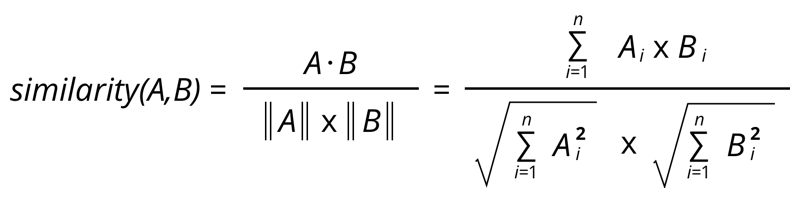

##**TÌM CÔNG TY TƯƠNG TỰ BẰNG COSIN-SIMILARITY**

In [34]:
from numpy import dot
from numpy.linalg import norm
X = [1,2]
Y = [2,2]
cos_sim = dot(X,Y) / (norm(X)*norm(Y))
print(cos_sim)

0.9486832980505138


In [35]:
# Thiết đặt thông số
tf = TfidfVectorizer(analyzer='word', min_df=0.0, stop_words=stopwords_lst)

# Chuyển cột dữ liệu đầu vào thành ma trận tf-idf
tfidf_matrix = tf.fit_transform(data.input_text)

#Tính giá trị tương đồng bằng matran n x n (Là tính cosin giữa 2 vector, cosin gần 1 thì càng // hay trùng nhau: [a, b] x [b, a] = [a, a])
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

cosine_similarities

array([[1.        , 0.25541962, 0.19742111, ..., 0.69819589, 0.21378235,
        0.0880656 ],
       [0.25541962, 1.        , 0.22706549, ..., 0.49426857, 0.35070297,
        0.21689079],
       [0.19742111, 0.22706549, 1.        , ..., 0.20739603, 0.14715563,
        0.06061936],
       ...,
       [0.69819589, 0.49426857, 0.20739603, ..., 1.        , 0.41369531,
        0.25584814],
       [0.21378235, 0.35070297, 0.14715563, ..., 0.41369531, 1.        ,
        0.33929977],
       [0.0880656 , 0.21689079, 0.06061936, ..., 0.25584814, 0.33929977,
        1.        ]])

In [36]:
cosine_similarities.shape

(478, 478)

In [37]:
#Xem ma trận độ tương đồng
df_show = pd.DataFrame(cosine_similarities)
df_show.head()

,0,1,2,3,4,5,6,7,8,9,...,468,469,470,471,472,473,474,475,476,477
0,1.000000,0.255420,0.197421,0.492068,0.174766,0.095982,0.169228,0.323820,0.386947,1.000000,...,0.133374,0.255420,1.000000,0.050035,0.378436,0.174377,0.394470,0.698196,0.213782,0.088066
1,0.255420,1.000000,0.227065,0.409230,0.249831,0.236388,0.140938,0.275044,0.253327,0.255420,...,0.068943,1.000000,0.255420,0.090311,0.236991,0.200561,0.481212,0.494269,0.350703,0.216891
2,0.197421,0.227065,1.000000,0.171714,0.069826,0.066069,0.108935,0.212590,0.070803,0.197421,...,0.053288,0.227065,0.197421,0.069804,0.046186,0.155019,0.201917,0.207396,0.147156,0.060619
3,0.492068,0.409230,0.171714,1.000000,0.244001,0.230871,0.085436,0.197341,0.429840,0.492068,...,0.067335,0.409230,0.492068,0.043520,0.431385,0.151670,0.469983,0.737601,0.342519,0.211830
4,0.174766,0.249831,0.069826,0.244001,1.000000,0.367899,0.664652,0.131076,0.830670,0.174766,...,0.098905,0.249831,0.174766,0.498510,0.257763,0.061675,0.611268,0.371735,0.390831,0.337556


In [38]:
#Hiển thị các công ty có chỉ số tương đồng 0.1-1 bằng màu
df_show.style.applymap(lambda x: "background-color: lightblue" if x>=1.0 else "background-color: green" if x>=0.5 and x<1.0 else "background-color: white")

Output hidden; open in https://colab.research.google.com to view.

####**BT1: Chọn 1 công ty -> hiển thị công ty tương tự**

In [66]:
def find_similar_companies_cos(cosine_similarities, data, top_n):
    top_similar_cos_find = {}
    df_cos_find = {}

    for idx, row in data.iterrows():
        # Bỏ chính nó ra bằng cách gán -1
        sim_scores = cosine_similarities[idx].copy()
        sim_scores[idx] = -1

        # Lấy top_n chỉ số công ty tương tự nhất
        similar_indices = sim_scores.argsort()[-top_n:][::-1]

        # Tạo danh sách (score, index)
        similar_items = [(cosine_similarities[idx][i], i) for i in similar_indices]
        top_similar_cos_find[idx] = similar_items

        # Lấy dòng dữ liệu công ty từ DataFrame
        similar_df = data.iloc[similar_indices].copy()
        similar_df["similarity_score"] = [cosine_similarities[idx][i] for i in similar_indices]
        df_cos_find[idx] = similar_df

    return top_similar_cos_find, df_cos_find, idx

# Gọi hàm với số công ty tương tự muốn lấy
top_similar_cos_find, df_cos_find, idx = find_similar_companies_cos(cosine_similarities, data, top_n=5)


# ID công ty đang tìm kiếm
target_idx = 0  # hoặc bất kỳ index nào bạn muốn

print(f"ID của công ty đang tìm kiếm: {target_idx}")
print("\nID của các công ty tương tự:")

# Lấy danh sách top công ty tương tự với công ty target_idx
for sim_idx, sim_score in top_similar_cos_find[target_idx]:
    print(f"ID: {sim_score}, Similarity_score: {sim_idx:.4f}")

# # Xem top công ty tương tự với công ty có index = 0
# print("Tóm tắt:", top_similar_cos_find[0])                # dạng [(score, index), ...]

ID của công ty đang tìm kiếm: 0

ID của các công ty tương tự:
ID: 17, Similarity_score: 1.0000
ID: 66, Similarity_score: 1.0000
ID: 102, Similarity_score: 1.0000
ID: 92, Similarity_score: 1.0000
ID: 455, Similarity_score: 1.0000


In [64]:
df_cos_find[target_idx]

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href,Company overview_new,Why you'll love working here_new,Our key skills_new,noidung_cty,input_text,similarity_score
17,17,APA Tech,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Vietnam,Monday_-_Friday,No_OT,APA Tech\nWe are a tech company led by tech pe...,Unknown,Unknown,"{'Da Nang': ['K144 Nguyễn Lương Bằng, Hòa Khán...",https://itviec.com/companies/apa-tech\n,apa tech công ty công nghệ lãnh đạo công nghệh...,không xác định,không xác định,apa tech công ty công nghệ lãnh đạo công nghệh...,IT_Outsourcing Software_Development_Outsourcin...,1.0
66,66,C-Labs Technology,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Vietnam,Monday_-_Friday,No_OT,.\n.,Unknown,Unknown,"{'Ha Noi': ['Tầng 2, Tòa nhà Hoàng Ngân Plaza,...",https://itviec.com/companies/c-labs-technology\n,,không xác định,không xác định,không xác định không xác định,IT_Outsourcing Software_Development_Outsourcin...,1.0
102,102,Công ty TNHH Chuyển đổi số & Đổi mới sáng tạo ...,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Vietnam,Monday_-_Friday,No_OT,"Viet Nam DX\nHiện nay, Chuyển đổi số đang trở ...",Unknown,Unknown,"{'Ha Noi': ['Khu đô thị Geleximco, Dương Nội, ...",https://itviec.com/companies/cong-ty-tnhh-chuy...,viet nam dx hiện đổi trở thành 1 chiến lược bắ...,không xác định,không xác định,viet nam dx hiện đổi trở thành 1 chiến lược bắ...,IT_Outsourcing Software_Development_Outsourcin...,1.0
92,92,Công ty cổ phần NIQ Việt Nam,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Vietnam,Monday_-_Friday,No_OT,Công ty cổ phần NIQ Việt Nam\nCông ty cổ phần ...,Unknown,Unknown,"{'Ha Noi': ['Tòa nhà Sannam, Số 78 phố Duy Tân...",https://itviec.com/companies/cong-ty-co-phan-n...,công ty cổ niq việt nam công ty cổ niq việt na...,không xác định,không xác định,công ty cổ niq việt nam công ty cổ niq việt na...,IT_Outsourcing Software_Development_Outsourcin...,1.0
455,455,VinaWeb,IT_Outsourcing,Software_Development_Outsourcing,1-50_employees,Vietnam,Monday_-_Friday,No_OT,VinaWeb\nĐược thành lập từ năm 2009 Sau 10 năm...,Unknown,Unknown,"{'Others': ['Tầng 6, Tòa nhà Hoàng Phát, số 4 ...",https://itviec.com/companies/vinaweb\n,vinaweb thành lập 2009 10 nỗ lực không ngừng h...,không xác định,không xác định,vinaweb thành lập 2009 10 nỗ lực không ngừng h...,IT_Outsourcing Software_Development_Outsourcin...,1.0


####**BT2: Gõ từ khóa vào và hiển thị list công ty tương tự**

In [41]:
# Thiết đặt thông số
tf = TfidfVectorizer(analyzer='word', min_df=0.0, stop_words=stopwords_lst)

# Chuyển cột dữ liệu đầu vào thành ma trận tf-idf
tfidf_matrix_2 = tf.fit_transform(data.noidung_cty)

In [89]:
from sklearn.metrics.pairwise import cosine_similarity

def search_similar_companies_cos(query_text_2, vectorizer, tfidf_matrix, data, top_n=5):
    # 1. Làm sạch từ khóa truy vấn
    cleaned_query = clean_pipeline(query_text_2)

    # 2. Chuyển thành vector TF-IDF (dạng 1×n)
    query_vector = tf.transform([cleaned_query])  # giữ nguyên từ điển cũ

    # 3. Tính độ tương đồng cosine với toàn bộ công ty
    sims = cosine_similarity(query_vector, tfidf_matrix_2)[0]  # kết quả là vector 1D

    # 4. Lấy top N công ty có điểm similarity cao nhất
    similar_indices = sims.argsort()[-top_n:][::-1]  # sắp xếp giảm dần

    # 5. Tạo kết quả danh sách điểm và chỉ số
    top_similarity_cos_search = [(sims[i], i) for i in similar_indices]

    # 6. Tạo DataFrame các công ty tương tự
    df_cos_search = data.iloc[similar_indices].copy()
    df_cos_search["similarity_score"] = [sims[i] for i in similar_indices]

    return top_similarity_cos_search , df_cos_search, query_text_2

top_similarity_cos_search , df_cos_search, query_text_2 = search_similar_companies_cos(query_text_2="CNTT chuyên về mảng Blockchain, AI. Công ty làm việc với khách hàng Nhật Bản", vectorizer=tf, tfidf_matrix=tfidf_matrix_2, data=data, top_n=1)


print (f"Từ khóa tìm kiếm: {query_text_2}")
print (f"\n\nID và chỉ số tương đồng của công ty gần nhất với từ khóa cần tìm là:")

# Vì top_n = 1 nên lấy phần tử đầu tiên trong top_similar_gem_search
sim_score, sim_idx = top_similarity_cos_search[0]
print(f"ID: {sim_idx}, Similarity_score: {sim_score:.4f}")

Từ khóa tìm kiếm: CNTT chuyên về mảng Blockchain, AI. Công ty làm việc với khách hàng Nhật Bản


ID và chỉ số tương đồng của công ty gần nhất với từ khóa cần tìm là:
ID: 0, Similarity_score: 0.3434


In [91]:
df_cos_search[['Company Name', 'noidung_cty']]

,Company Name,noidung_cty
0,1BITLAB Technology,1bitlab technology công ty cổ công nghệ 1bitla...
